In [52]:
import neuraltda.simpComp as sc
import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
from ephys import rasters
import pickle
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import seaborn as sns
from importlib import reload
sns.set_context('poster')
sns.set_style('white')
%matplotlib inline
reload(sa)
reload(sc)

<module 'neuraltda.simpComp' from '/home/brad/code/NeuralTDA/neuraltda/simpComp.py'>

In [84]:
nsamples2 = 5
d = 1
def loss_new(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new_likelihood(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.Likelihood(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new_JS(a, beta):
    #Calculate JS according to Biam Dedom, using entropy
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    mJS = np.mean(JSsave)
    std = np.std(KLsave)
    stdJS = np.std(JSsave)
    stderr = std / np.sqrt(nsamples2)
    stderrJS = stdJS / np.sqrt(nsamples2)
    return (m, mJS, stderr, stderrJS)

def loss_new_KLmatlog(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        #KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

In [85]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 1000
a = 0.02
probs = (a*np.ones((ncells, 1)))
nsamples = 1
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

In [86]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.06, 50)

beta = 0.15

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, stderr) = loss_new(x, beta)
        KL.append(m)
        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00612244897959
error2
error2
error2
error2
0.00724489795918
error2
error2
error2
error2
0.00836734693878
error2
error2
error2
error2
0.00948979591837
error2
error2
error2
0.010612244898
error2
error2
error2
0.0117346938776
error2
error2
error2
error2
0.0128571428571
error2
0.0139795918367
0.0151020408163
0.0162244897959
error2
0.0173469387755
0.0184693877551
0.0195918367347
0.0207142857143
0.0218367346939
0.0229591836735
0.0240816326531
0.0252040816327
0.0263265306122
0.0274489795918
0.0285714285714
0.029693877551
0.0308163265306
0.0319387755102
0.0330612244898
0.0341836734694
0.035306122449
0.0364285714286
0.0375510204082
0.0386734693878
0.0397959183673
0.0409183673469
0.0420408163265
0.0431632653061
0.0442857142857
0.0454081632653
0.0465306122449
0.0476530612245
0.0487755102041
0.0498979591837
0.0510204081633
0.0521428571429
0.0532653061224
0.054387755102
0.0555102040816
0.0566326530612
0.0577551020408
0.0588775510204
0.06


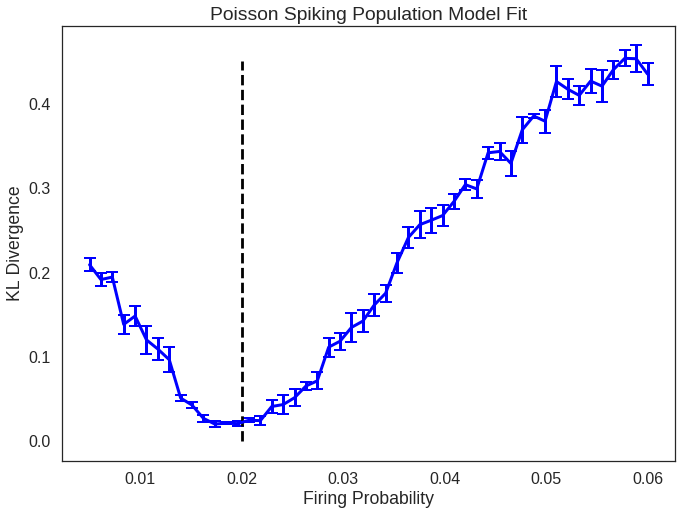

In [87]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, 0.45, 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [88]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.06, 20)

beta = -1.

#likelihood

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, stderr) = loss_new_likelihood(x, beta)
        KL.append(m)
        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00789473684211
error2
error2
error2
0.0107894736842
error2
error2
0.0136842105263
0.0165789473684
0.0194736842105
0.0223684210526
0.0252631578947
0.0281578947368
0.0310526315789
0.0339473684211
0.0368421052632
0.0397368421053
0.0426315789474
0.0455263157895
0.0484210526316
0.0513157894737
0.0542105263158
0.0571052631579
0.06


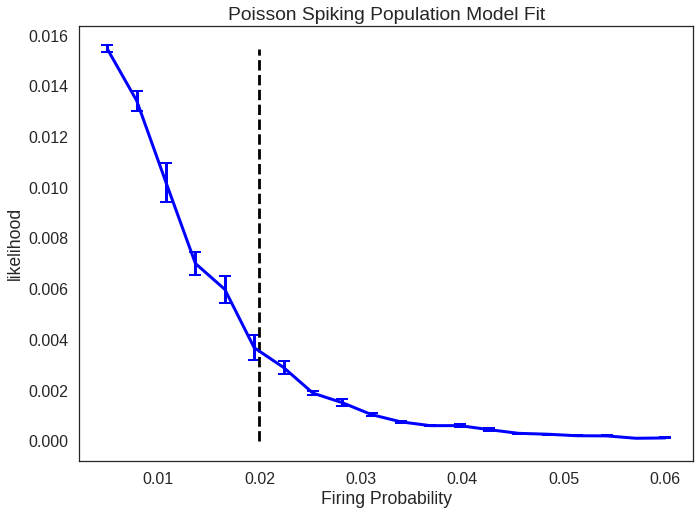

In [89]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('likelihood')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [90]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.05, 20)

beta = -1

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, mjs, stderr, stderrjs) = loss_new_JS(x, beta)
        KL.append(m)
        JS.append(mjs)
        KLerr.append(stderr)
        JSerr.append(stderrjs)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00736842105263
error2
error2
error2
0.00973684210526
error2
error2
0.0121052631579
0.0144736842105
0.0168421052632
0.0192105263158
0.0215789473684
0.0239473684211
0.0263157894737
0.0286842105263
0.0310526315789
0.0334210526316
0.0357894736842
0.0381578947368
0.0405263157895
0.0428947368421
0.0452631578947
0.0476315789474
0.05


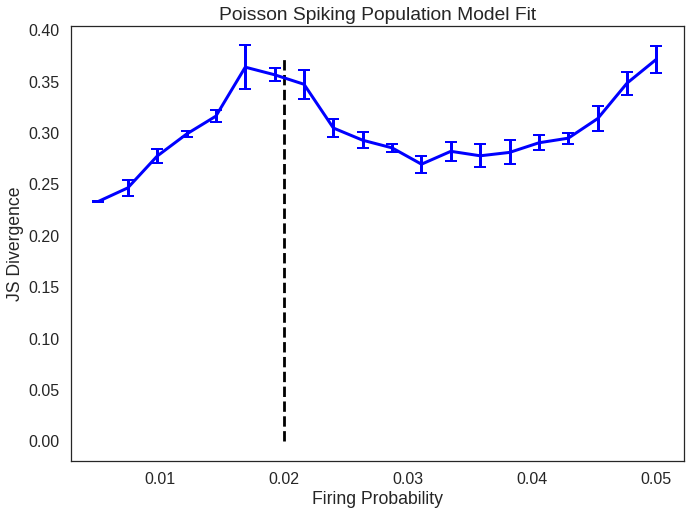

In [91]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, JS, yerr=JSerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(JS), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('JS Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')